#### Import packages

In [1]:
# import packages to us
import os
import chess
import chess.engine
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', None)
import numpy as np
import itertools
import zentables
import seaborn as sns
import matplotlib.pyplot as plt

#### Set up folders to stockfish (chess engine) and data csv file

Download stockfish from: https://stockfishchess.org/download/

I'm using version 15 here. Frustratingly, what version you use seems to matter for some things, but probably just using the most recent is a way to go.

Download data from: http://csslab.cs.toronto.edu/datasets/#maia_kdd

I'm using the january CSV here

In [2]:
stockfish_path = "/Users/erussek/Dropbox/Griffiths_Lab_Stuff/Chess_Engines/stockfish/15/bin/stockfish"
chess_data_folder = '/Users/erussek/Dropbox/Griffiths_Lab_Stuff/Chess_Data'
chess_csv_file = 'lichess_db_standard_rated_2019-01.csv'
chess_data_fullfile = os.path.join(chess_data_folder,chess_csv_file)


#### Read in 1000 rows of data

Each row is a move from a game (game_id), made by a player (player_id), we also have elo, white/black, etc.
"board" gives the "fen" - this the location of each piece on the position - prior to the move
"clock" gives the clock time at the end of the turn.
"time_control" specifies what the initial clock setting is for each player (e.g. 600 seconds) and also how much time they get back after each move (this comes after the "+"). "move" specifies what move the player made. "white_active" specifies which player (black or white) made the move

In [13]:
data_raw = pd.read_csv(chess_data_fullfile, nrows=50000)
data_raw.head()

/var/folders/s3/06m5bv8s03v5c2y_thvlc6qr0000gp/T/ipykernel_40962/1202532834.py:1: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  data_raw = pd.read_csv(chess_data_fullfile, nrows=50000)


,game_id,type,result,white_player,black_player,white_elo,black_elo,time_control,num_ply,termination,white_won,black_won,no_winner,move_ply,move,cp,cp_rel,cp_loss,is_blunder_cp,winrate,winrate_elo,winrate_loss,is_blunder_wr,opp_winrate,white_active,active_elo,opponent_elo,active_won,is_capture,clock,opp_clock,clock_percent,opp_clock_percent,low_time,board,active_bishop_count,active_knight_count,active_pawn_count,active_queen_count,active_rook_count,is_check,num_legal_moves,opp_bishop_count,opp_knight_count,opp_pawn_count,opp_queen_count,opp_rook_count
0,mAEz2AcC,Rapid,0-1,AliKhaled,ifospor,1702,1628,600+0,36,Normal,False,True,False,0,e2e4,0.1,0.10,-0.02,False,0.5295,0.4758,0.0000,False,0.5244,True,1702,1628,False,False,600.0,600.0,0.000,0.000,False,rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...,2,2,8,2,2,0,20,2,2,8,2,2
1,mAEz2AcC,Rapid,0-1,AliKhaled,ifospor,1702,1628,600+0,36,Normal,False,True,False,1,e7e5,0.12,-0.12,0.25,False,0.5244,0.4456,0.0192,False,0.5295,False,1628,1702,True,False,600.0,600.0,0.000,0.000,False,rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR ...,3,2,8,2,2,0,20,2,2,8,2,2
2,mAEz2AcC,Rapid,0-1,AliKhaled,ifospor,1702,1628,600+0,36,Normal,False,True,False,2,g1f3,0.37,0.37,0.14,False,0.5749,0.4994,0.0084,False,0.5052,True,1702,1628,False,False,598.0,600.0,0.003,0.000,False,rnbqkbnr/pppp1ppp/8/4p3/4P3/8/PPPP1PPP/RNBQKBN...,2,2,8,2,2,0,29,2,2,8,2,2
3,mAEz2AcC,Rapid,0-1,AliKhaled,ifospor,1702,1628,600+0,36,Normal,False,True,False,3,b8c6,0.23,-0.23,-0.08,False,0.5134,0.4456,-0.0109,False,0.5664,False,1628,1702,True,False,599.0,598.0,0.002,0.003,False,rnbqkbnr/pppp1ppp/8/4p3/4P3/5N2/PPPP1PPP/RNBQK...,3,2,8,2,2,0,29,2,2,8,2,2
4,mAEz2AcC,Rapid,0-1,AliKhaled,ifospor,1702,1628,600+0,36,Normal,False,True,False,4,f1c4,0.15,0.15,0.05,False,0.5295,0.4758,0.0000,False,0.5244,True,1702,1628,False,False,596.0,599.0,0.007,0.002,False,r1bqkbnr/pppp1ppp/2n5/4p3/4P3/5N2/PPPP1PPP/RNB...,2,2,8,2,2,0,27,2,2,8,2,2


#### Filter data to only include moves from games with certain time-control settings and also less than x number of pieces on the board


In [15]:
# what game types do we care about? filter dataframe to only include these time-control settings (these occur on first page) - new name for df is data_filt
game_time_types = ['60+0', '120+1', '180+0',
                   '180+2', '300+0', '300+3',
                   '600+0', '600+5', '900+10',
                   '1800+0', '1800+20']

# filter based on if it's in these game settings... 
data_filt = data_raw.loc[data_raw.time_control.isin(game_time_types)].reset_index(drop = True)

def count_pieces(this_fen):
    
    n_pieces = 0
    for i in this_fen:
        if i == ' ':
            break
        
        if i.isalpha():
            n_pieces += 1
    
    return n_pieces

data_filt['n_pieces'] = data_filt.apply(lambda row : count_pieces(row['board']), axis = 1)

data_filt = data_filt.loc[(data_filt.n_pieces < 11) & (data_filt.n_pieces > 7),:].reset_index(drop=True)


In [16]:
data_filt.to_csv('Filtered_Data.csv')

#### Functions to convert stockfish's scoring into sensible metrics of estiamted win/loss probability


In [17]:
# for cp to wp
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def cp_to_wp(score_val_cp_white):
    """
    Converts centipawn score val (signed with white pos/black neg) to win prob for white
    
    Args:
        score_val_cp_white: centipawn value (signed with white positive black negative) for position
    Returns:
        win probability: measure between 0 and 1 giving probability of white win
        Note: taken for logistic regression model applied to predict win given centipawn games
    """
    this_const = -0.045821224987387915;
    this_board_score_val = 0.002226678310106879
    #return sigmoid(log_reg_cp.params['const'] + log_reg_cp.params['board_score_val']*score_val_cp_white)
    return sigmoid(this_const + this_board_score_val*score_val_cp_white)

def mate_to_wp(score_val_mate):
    """
    Converts plys from mate to win prob (for the player who is within reach of mate)
    """
    # return sigmoid(log_reg_mate.params['const'] + log_reg_mate.params['score_val_pos']*np.abs(score_val_mate))
    return sigmoid(3.6986223572286208 + -0.05930670977061789*np.abs(score_val_mate))


# add support for if mate == 0!!!!!!!
def process_score(this_score, white_active):
    """
    Input:
    this score:  what is returned from stockfish
    white active: is whether it is white's move
    
    Output:
    score_dict: contains
    """
    
    white_score = this_score.white()
    is_mate = white_score.is_mate()
    
    if is_mate:
        score_type = 'mate'
        score_val = white_score.mate() # this is framed as white'
        if score_val > 0:
            wp = mate_to_wp(score_val) # this is framed as whichever side is close to mate
        elif score_val < 0:
            wp = 1 - mate_to_wp(score_val)
        elif score_val == 0:
            wp = 1 if white_active else 0
            # 1 or -1 depending on whose move this is.... so process score needs to take in who is active
    else: # centipawn...
        score_type = 'cp'
        score_val = white_score.score()
        wp = cp_to_wp(score_val)
    
    wp_active = wp if white_active else 1 - wp
        
    #score_dict = {'type': score_type, 'val': score_val, 'wp': wp}
    return wp_active


#### Initialize the engine

I've used the python-chess package to communicate with the engine.

https://python-chess.readthedocs.io/en/latest/engine.html

In [18]:
engine = chess.engine.SimpleEngine.popen_uci(stockfish_path)

### Select and display random position

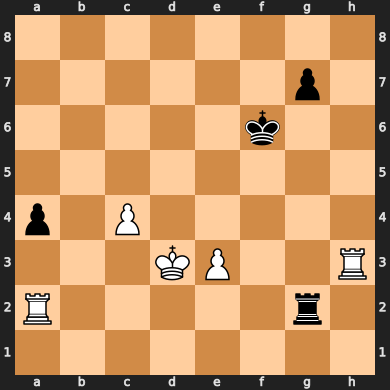

black to move
move selected: g2a2


In [24]:
data_idx = 80
this_row = data_filt.loc[data_idx,:]
this_fen = this_row.board
this_white_active = this_row.white_active
player_to_move = "white" if this_white_active else "black"

current_board = chess.Board(this_fen);

display(current_board)
print('{} to move'.format(player_to_move))

this_move = this_row.move
print('move selected: {}'.format(this_move))


In [25]:
data_filt

,game_id,type,result,white_player,black_player,white_elo,black_elo,time_control,num_ply,termination,white_won,black_won,no_winner,move_ply,move,cp,cp_rel,cp_loss,is_blunder_cp,winrate,winrate_elo,winrate_loss,is_blunder_wr,opp_winrate,white_active,active_elo,opponent_elo,active_won,is_capture,clock,opp_clock,clock_percent,opp_clock_percent,low_time,board,active_bishop_count,active_knight_count,active_pawn_count,active_queen_count,active_rook_count,is_check,num_legal_moves,opp_bishop_count,opp_knight_count,opp_pawn_count,opp_queen_count,opp_rook_count,n_pieces
0,WagNiFfQ,Blitz,1/2-1/2,batyko,ahli_blunder,1826,1826,300+0,107,Time forfeit,False,False,True,82,c4d5,None,-inf,NaN,False,NaN,NaN,NaN,False,NaN,True,1826,1826,False,True,210.0,21.0,0.300,0.930,False,8/5p2/pK3k2/2pr4/2P5/3P4/7p/6b1 w - - 0 42,0,0,2,0,0,0,8,1,0,4,0,1,10
1,WagNiFfQ,Blitz,1/2-1/2,batyko,ahli_blunder,1826,1826,300+0,107,Time forfeit,False,False,True,83,h2h1q,None,inf,NaN,False,NaN,NaN,NaN,False,NaN,False,1826,1826,False,False,20.0,210.0,0.933,0.300,True,8/5p2/pK3k2/2pP4/8/3P4/7p/6b1 b - - 0 42,2,0,4,0,0,0,15,0,0,2,0,0,9
2,WagNiFfQ,Blitz,1/2-1/2,batyko,ahli_blunder,1826,1826,300+0,107,Time forfeit,False,False,True,84,d5d6,None,-inf,NaN,False,NaN,NaN,NaN,False,NaN,True,1826,1826,False,False,209.0,20.0,0.303,0.933,False,8/5p2/pK3k2/2pP4/8/3P4/8/6bq w - - 0 43,0,0,2,0,0,0,8,1,0,3,1,0,9
3,WagNiFfQ,Blitz,1/2-1/2,batyko,ahli_blunder,1826,1826,300+0,107,Time forfeit,False,False,True,85,h1d5,None,inf,NaN,False,NaN,NaN,NaN,False,NaN,False,1826,1826,False,False,18.0,209.0,0.940,0.303,True,8/5p2/pK1P1k2/2p5/8/3P4/8/6bq b - - 0 43,2,0,3,1,0,0,26,0,0,2,0,0,9
4,WagNiFfQ,Blitz,1/2-1/2,batyko,ahli_blunder,1826,1826,300+0,107,Time forfeit,False,False,True,86,b6c7,None,-inf,NaN,False,NaN,NaN,NaN,False,NaN,True,1826,1826,False,False,207.0,18.0,0.310,0.940,False,8/5p2/pK1P1k2/2pq4/8/3P4/8/6b1 w - - 1 44,0,0,2,0,0,0,6,1,0,3,1,0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
972,VcsNI44I,Blitz,0-1,Pemered,chessok-ir,2167,2068,180+2,88,Normal,False,True,False,85,b1g6,-64.48,64.48,0.53,False,NaN,NaN,NaN,False,NaN,False,2068,2167,True,False,36.0,17.0,0.856,0.932,False,8/p3Qpkp/1p6/2p3K1/7P/8/8/1q6 b - - 5 43,1,0,5,1,0,0,25,0,0,1,1,0,10
973,VcsNI44I,Blitz,0-1,Pemered,chessok-ir,2167,2068,180+2,88,Normal,False,True,False,86,g5f4,-63.95,-63.95,0.29,False,NaN,NaN,NaN,False,NaN,True,2167,2068,False,False,16.0,36.0,0.936,0.856,True,8/p3Qpkp/1p4q1/2p3K1/7P/8/8/8 w - - 6 44,0,0,1,1,0,1,1,0,0,5,1,0,10
974,VcsNI44I,Blitz,0-1,Pemered,chessok-ir,2167,2068,180+2,88,Normal,False,True,False,87,g6f6,-64.24,64.24,0.68,False,NaN,NaN,NaN,False,NaN,False,2068,2167,True,False,37.0,16.0,0.852,0.936,False,8/p3Qpkp/1p4q1/2p5/5K1P/8/8/8 b - - 7 44,1,0,5,1,0,0,25,0,0,1,1,0,10
975,585x5u0q,Bullet,1-0,Ali-Qurbanli,nejc4577,1570,1569,60+0,89,Time forfeit,True,False,False,87,c3c2,7.44,-7.44,0.31,False,0.2228,0.1713,0.0101,False,0.8119,False,1569,1570,False,False,1.0,4.0,0.983,0.933,True,7R/8/4kp2/3bp3/7P/2p2PK1/5B2/8 b - - 0 44,2,0,3,0,0,0,16,1,0,2,0,1,10


#### Get the best move and then re-evaluate the resultant board state that it produces by pushing it onto the board
Note that we need to evaluate moves by pushing them onto the board so that we can also evaluate moves that stockfish didn't select itself

In [26]:
# get the best move for the full board

eval_depth = 9

engine.configure({"Clear Hash": None})
info = engine.analyse(current_board, chess.engine.Limit(depth=eval_depth))
best_move_full = info['pv'][0].uci()
print('move: '  + best_move_full)

# evaluate the best move
new_board=current_board.copy()
new_board.push_uci(best_move_full)
engine.configure({"Clear Hash": None})
info = engine.analyse(new_board, chess.engine.Limit(depth=eval_depth))
best_move_full_score = process_score(info['score'], this_white_active)
print('score: ' + str(best_move_full_score))


move: g2a2
score: 0.5114533023854683


#### Get each set of moves which can be removed to define each construal.

In [27]:
full_piece_map = current_board.piece_map()
eligible_keys_for_removal = [key for key,val in full_piece_map.items() if ((val != chess.Piece.from_symbol('K')) & (val != chess.Piece.from_symbol('k')))]
eligible_vals_for_removal = [val.symbol() for key,val in full_piece_map.items() if ((val != chess.Piece.from_symbol('K')) & (val != chess.Piece.from_symbol('k')))]
eligible_squares_for_removal = [eligible_vals_for_removal[i]+chess.square_name(eligible_keys_for_removal[i]) for i in range(len(eligible_keys_for_removal))]

# want to get every combination of keys we might remove
def findsubsets(s, n):
    return list(itertools.combinations(s, n))

key_removal_subsets = []
square_removal_subsets = []
n_pieces = []

n_eligible_pieces_for_removal = len(eligible_squares_for_removal)
for n in range(0,n_eligible_pieces_for_removal+1):
    key_removal_subsets.extend(findsubsets(eligible_keys_for_removal,n))
    these_subsets = findsubsets(eligible_squares_for_removal,n)
    square_removal_subsets.extend(these_subsets)
    #n_pieces.append(1 + n_eligible_pieces_for_removal - len(these_subsets))

In [28]:
print("Eligible sets of pieces for removal: ")
display(square_removal_subsets)

Eligible sets of pieces for removal: 


[(),
 ('pg7',),
 ('Pc4',),
 ('pa4',),
 ('Rh3',),
 ('Pe3',),
 ('rg2',),
 ('Ra2',),
 ('pg7', 'Pc4'),
 ('pg7', 'pa4'),
 ('pg7', 'Rh3'),
 ('pg7', 'Pe3'),
 ('pg7', 'rg2'),
 ('pg7', 'Ra2'),
 ('Pc4', 'pa4'),
 ('Pc4', 'Rh3'),
 ('Pc4', 'Pe3'),
 ('Pc4', 'rg2'),
 ('Pc4', 'Ra2'),
 ('pa4', 'Rh3'),
 ('pa4', 'Pe3'),
 ('pa4', 'rg2'),
 ('pa4', 'Ra2'),
 ('Rh3', 'Pe3'),
 ('Rh3', 'rg2'),
 ('Rh3', 'Ra2'),
 ('Pe3', 'rg2'),
 ('Pe3', 'Ra2'),
 ('rg2', 'Ra2'),
 ('pg7', 'Pc4', 'pa4'),
 ('pg7', 'Pc4', 'Rh3'),
 ('pg7', 'Pc4', 'Pe3'),
 ('pg7', 'Pc4', 'rg2'),
 ('pg7', 'Pc4', 'Ra2'),
 ('pg7', 'pa4', 'Rh3'),
 ('pg7', 'pa4', 'Pe3'),
 ('pg7', 'pa4', 'rg2'),
 ('pg7', 'pa4', 'Ra2'),
 ('pg7', 'Rh3', 'Pe3'),
 ('pg7', 'Rh3', 'rg2'),
 ('pg7', 'Rh3', 'Ra2'),
 ('pg7', 'Pe3', 'rg2'),
 ('pg7', 'Pe3', 'Ra2'),
 ('pg7', 'rg2', 'Ra2'),
 ('Pc4', 'pa4', 'Rh3'),
 ('Pc4', 'pa4', 'Pe3'),
 ('Pc4', 'pa4', 'rg2'),
 ('Pc4', 'pa4', 'Ra2'),
 ('Pc4', 'Rh3', 'Pe3'),
 ('Pc4', 'Rh3', 'rg2'),
 ('Pc4', 'Rh3', 'Ra2'),
 ('Pc4', 'Pe3', 'rg2'),
 ('Pc4', 

In [53]:
findsubsets(eligible_keys_for_removal,0)

[()]

In [54]:
len(square_removal_subsets)

128

#### Get action for each construal

In [29]:
construal_fens = []
construal_n_pieces = []
construal_selected_actions = []
construal_pieces = []

new_board = current_board.copy()
for removed_pieces in key_removal_subsets:
    new_piece_map = full_piece_map.copy()
    
    for piece in removed_pieces:
        del new_piece_map[piece]
    
    new_board.set_piece_map(new_piece_map)
    
    # get the moves in this construal
    this_construal_pieces = [val.symbol()+chess.square_name(key) for key,val in new_piece_map.items()]
    construal_pieces.append(this_construal_pieces)
    
    #display(new_board)
    construal_fens.append(new_board.fen())
    
    # add 2 for the kings
    construal_n_pieces.append(2 + n_eligible_pieces_for_removal - len(removed_pieces))
    
    # clear hash and get best move
    engine.configure({"Clear Hash": None})
    info = engine.analyse(new_board, chess.engine.Limit(depth=eval_depth))
    new_best_move = info['pv'][0].uci()
    construal_selected_actions.append(new_best_move)

construal_selected_actions = np.array(construal_selected_actions)


In [30]:
construal_pieces

[['pg7', 'kf6', 'Pc4', 'pa4', 'Rh3', 'Pe3', 'Kd3', 'rg2', 'Ra2'],
 ['kf6', 'Pc4', 'pa4', 'Rh3', 'Pe3', 'Kd3', 'rg2', 'Ra2'],
 ['pg7', 'kf6', 'pa4', 'Rh3', 'Pe3', 'Kd3', 'rg2', 'Ra2'],
 ['pg7', 'kf6', 'Pc4', 'Rh3', 'Pe3', 'Kd3', 'rg2', 'Ra2'],
 ['pg7', 'kf6', 'Pc4', 'pa4', 'Pe3', 'Kd3', 'rg2', 'Ra2'],
 ['pg7', 'kf6', 'Pc4', 'pa4', 'Rh3', 'Kd3', 'rg2', 'Ra2'],
 ['pg7', 'kf6', 'Pc4', 'pa4', 'Rh3', 'Pe3', 'Kd3', 'Ra2'],
 ['pg7', 'kf6', 'Pc4', 'pa4', 'Rh3', 'Pe3', 'Kd3', 'rg2'],
 ['kf6', 'pa4', 'Rh3', 'Pe3', 'Kd3', 'rg2', 'Ra2'],
 ['kf6', 'Pc4', 'Rh3', 'Pe3', 'Kd3', 'rg2', 'Ra2'],
 ['kf6', 'Pc4', 'pa4', 'Pe3', 'Kd3', 'rg2', 'Ra2'],
 ['kf6', 'Pc4', 'pa4', 'Rh3', 'Kd3', 'rg2', 'Ra2'],
 ['kf6', 'Pc4', 'pa4', 'Rh3', 'Pe3', 'Kd3', 'Ra2'],
 ['kf6', 'Pc4', 'pa4', 'Rh3', 'Pe3', 'Kd3', 'rg2'],
 ['pg7', 'kf6', 'Rh3', 'Pe3', 'Kd3', 'rg2', 'Ra2'],
 ['pg7', 'kf6', 'pa4', 'Pe3', 'Kd3', 'rg2', 'Ra2'],
 ['pg7', 'kf6', 'pa4', 'Rh3', 'Kd3', 'rg2', 'Ra2'],
 ['pg7', 'kf6', 'pa4', 'Rh3', 'Pe3', 'Kd3', 'Ra2'],
 

#### Evaluate each action selected in each construal


In [31]:
unique_construal_selected_actions = np.unique(construal_selected_actions)

action_scores_orig_format = {}
action_scores_processed = {}

construal_benefits = np.zeros(len(construal_selected_actions))
for this_move in unique_construal_selected_actions:

    # for each construal selected action, push it onto the board
    new_board = current_board.copy()
    new_board.push_uci(this_move)
    
    engine.configure({"Clear Hash": None})
    info = engine.analyse(new_board, chess.engine.Limit(depth=eval_depth))

    action_scores_orig_format[this_move] = info['score']
    processed_score = process_score(info['score'], this_white_active)
    action_scores_processed[this_move] = processed_score
    construal_benefits[construal_selected_actions == this_move] = processed_score

ValueError: illegal uci: 'f6g7' in 8/6p1/5k2/8/p1P5/3KP2R/R5r1/8 b - - 5 49

In [ ]:
# construal_benefits

In [ ]:
# construal_n_pieces

In [ ]:
CP_strings = [' '.join(cp) for cp in construal_pieces]

res_df = pd.DataFrame({'construal': CP_strings, 'num_pieces': construal_n_pieces, 'action': construal_selected_actions, 'value': construal_benefits})
res_df.zen.pretty()

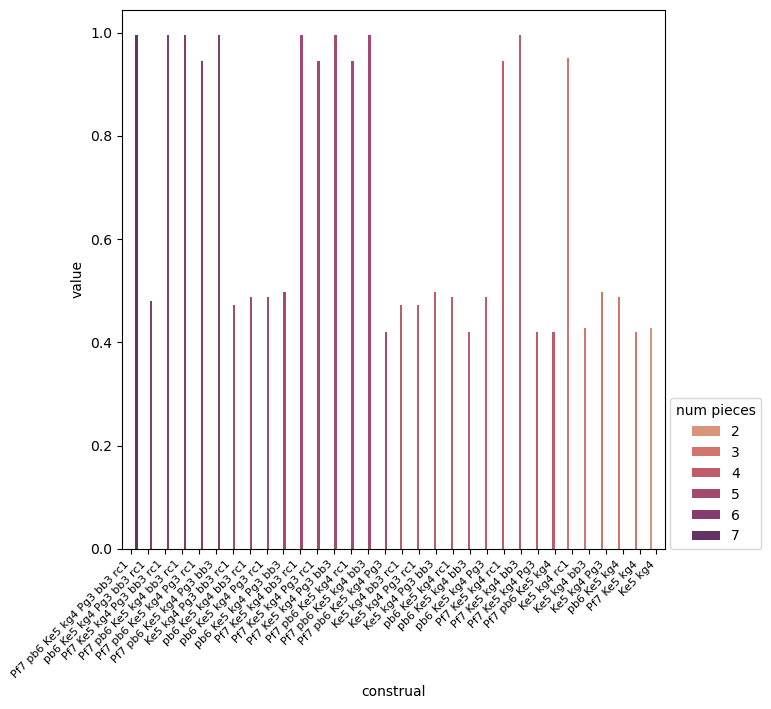

In [144]:

fig,ax = plt.subplots(1,figsize=(7,7),dpi=100)
sns.barplot(data=res_df, x="construal", y="value", hue = 'num_pieces', palette = 'flare', ax=ax)
ax.set_xticklabels(res_df.construal, rotation=45, ha='right', fontsize=8);
ax.legend(title = 'num pieces', loc=(1.01,0))
#ax.bar_label(res_df.action.values)


In [135]:
res_df.action.values

array(['b3f7', 'c1d1', 'b3f7', 'b3f7', 'c1f1', 'b3f7', 'c1c6', 'b6b5',
       'b6b5', 'g4g3', 'b3f7', 'c1f1', 'b3f7', 'c1f1', 'b3f7', 'g4f3',
       'c1c6', 'c1c6', 'g4g3', 'b6b5', 'g4f3', 'b6b5', 'c1f1', 'b3f7',
       'g4f3', 'g4f3', 'c1e1', 'g4g5', 'g4g3', 'b6b5', 'g4f3', 'g4g5'],
      dtype=object)